In [1]:
%reload_ext autoreload
%autoreload 2
%config Completer.use_jedi=False

In [13]:
import sample_model
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch.nn as nn
import glob
import itertools
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import cv2
import imageio
import kornia
import kornia.augmentation as K
import pytorch_lightning as pl

try:
    get_ipython().__class__.__name__
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm

# Dataset

In [3]:
sample_model.test_model()

All checks passed


In [4]:
DATA = Path('sample_levin_dataset')

In [5]:
def get_dataset_files(train:Path, test:Path=None):
    train = Path(train)
    files = train.rglob("*.png")
    if test is not None:
        test = Path(test)
        files = itertools.chain(test.rglob("*.png"))
    files = list(files)
    train_files =        list(filter(lambda x: "train" in str(x), files))
    test_files  =        list(filter(lambda x: "test"  in str(x), files))
    train_x     = sorted(list(filter(lambda x: "blur"  in str(x), train_files)))
    train_y     = sorted(list(filter(lambda x: "sharp" in str(x), train_files)))
    test_x      = sorted(list(filter(lambda x: "blur"  in str(x), test_files)))
    test_y      = sorted(list(filter(lambda x: "sharp" in str(x), test_files)))
            
    return list(zip(train_x, train_y)), list(zip(test_x, test_y))

In [6]:
train_files, test_files = get_dataset_files(DATA)

In [7]:
class DeblurDataset(Dataset):
    def __init__(self, files, stats=None):
        self.files    = files
        self.toTensor = transforms.ToTensor()
        self.stats = stats
        if self.stats is not None:
            self.normalize = kornia.augmentation.Normalize(*self.stats)
        else:
            self.normalize = lambda x: x
    
    def __len__(self):
        return len(self.files)
    
    def readImage(self, path:str):
        return self.toTensor(Image.open(str(path)))
    
    def __getitem__(self, idx):
        blurred = self.readImage(self.files[idx][0])
        sharp   = self.readImage(self.files[idx][1])
        return self.normalize(blurred), self.normalize(sharp)

In [8]:
train = DeblurDataset(train_files)
test  = DeblurDataset(test_files)

### DataLoader Experiments

In [25]:
k_transforms = nn.Sequential(K.RandomHorizontalFlip())

In [11]:
class GPUIter:
    def __init__(self, dl, transforms=lambda x: x, device='cpu'):
        self.dl = dl
        self.transforms = transforms
        self.device = device
        
    def __iter__(self):
        self.iterator = iter(self.dl)
        return self
        
    def __next__(self):
        try:
            x, y = next(self.iterator)
        except StopIteration:
            raise StopIteration
        return self.transforms(x).to(self.device), self.transforms(y).to(self.device)

In [12]:
class GPUDataLoader(DataLoader):
    def __init__(self, transforms=lambda x: x, device='cpu', *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.transforms = transforms
        self.device = device
        
    def __next__(self):
        try:
            x, y = super().next()
        except StopIteration:
            raise StopIteration
        return self.transforms(x).to(self.device), self.transforms(y).to(self.device)

In [15]:
dl = GPUDataLoader(transforms=k_transforms, device='cpu', dataset=train)

In [16]:
dl = DataLoader(train, batch_size=1, shuffle=True)
for i, b in enumerate(GPUIter(dl, k_transforms)): print(i, end=" ")

0 1 2 3 

# PyTorch Lightning Data Module

In [56]:
class DeblurDataModule(pl.LightningDataModule):
    def __init__(self, train:Path, test:Path=None, bs=1, transforms=None, stats=None, size=(256,256),
                 train_files=None, valid_files=None):
        self.train      = train
        self.test       = test
        self.bs         = bs
        
        if train_files is not None:
            if valid_files is None: 
                raise Exception("Please provide the valid_files argument")
            else:
                self.train_files, self.valid_files = train_files, valid_files
        else:
            self.train_files, self.valid_files = self.get_dataset_files(self.train, self.test)
        
        self.transforms = [kornia.Resize(size=size, interpolation='bicubic')]
        self.transforms +=list(transforms) if transforms is not None else self.get_transforms()
        self.stats      = stats
        
        # Adding Transform for Normalizing Data
        if self.stats is None:
            tmp_ds = DeblurDataset(self.train_files)
            means = torch.zeros_like(tmp_ds[0][0].mean((1,2)))
            stds  = torch.zeros_like(tmp_ds[0][0].std((1,2)))
            
            factor = 0.5
            print(f"Calculating dataset stats with a {int(factor * 100)}% random subset of training data")
            for i in tqdm(torch.randint(0, len(tmp_ds), (int(factor*len(tmp_ds)),))):
                means += tmp_ds[i][0].mean((1,2))
                stds  += tmp_ds[i][0].std((1,2))
                
            means /= factor * len(tmp_ds)
            stds  /= factor * len(tmp_ds)
            self.stats = (means, stds)
            
        self.normalize_func   = kornia.augmentation.Normalize(*self.stats)
        self.denormlaize_func = kornia.augmentation.Denormalize(*self.stats)
        
#         self.train_transforms = self.transforms
#         self.valid_transforms = self.transforms
#         self.test_transforms  = self.transforms
        
    
    def setup(self, stage:str = None):
        if stage == 'fit' or stage is None:
            self.train_ds = DeblurDataset(self.train_files, self.stats)
            self.valid_ds = DeblurDataset(self.valid_files, self.stats)
            self.dims = self.train_ds[0][0].shape
            
        if stage == 'test' or stage is None:
            self.test_ds = DeblurDataset(self.valid_files, self.stats)
            self.dims = getattr(self, 'dims', self.test_ds[0][0].shape)
            
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.bs, num_workers=8, pin_memory=True)
    
    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.bs, num_workers=8, pin_memory=True)
    
    def test_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.bs, num_workers=8, pin_memory=True)
        
    
    def get_dataset_files(self, train:Path, test:Path=None):
        train = Path(train)
        files = train.rglob("*.png")
        if test is not None:
            test = Path(test)
            files = itertools.chain(test.rglob("*.png"))
        files = list(files)
        train_files =        list(filter(lambda x: "train" in str(x), files))
        test_files  =        list(filter(lambda x: "test"  in str(x), files))
        train_x     = sorted(list(filter(lambda x: "blur"  in str(x), train_files)))
        train_y     = sorted(list(filter(lambda x: "sharp" in str(x), train_files)))
        test_x      = sorted(list(filter(lambda x: "blur"  in str(x), test_files)))
        test_y      = sorted(list(filter(lambda x: "sharp" in str(x), test_files)))

        return list(zip(train_x, train_y)), list(zip(test_x, test_y))
    
    
    def get_transforms(self):
        # TODO: Add RandomAffine, Rotate, Scale, Etc.
        return [K.RandomHorizontalFlip(), K.RandomVerticalFlip()]
    
    
    def set_size(self, size):
        self.size = size
        self.transforms[0] = kornia.Resize(size=size, interpolation='bicubic')
        
    
    def show_batch(self, n=2):
        """ `n` is the number of batches to view """
        dl = iter(self.train_dataloader())
        batches = [next(dl) for i in range(n)]
        num_images = batches[0][0].shape[0] * n
        fig, axes = plt.subplots(nrows=num_images, ncols=2, figsize=(8, 2*num_images))
        row = 0
        for i in range(n):
            b = augment_image_pair(batches[i], self.transforms)
            for j in range(b[0].shape[0]):
                im1 = self.denormlaize_func(b[0][j])
                im2 = self.denormlaize_func(b[1][j])
                im1 = im1.detach().cpu().numpy().transpose(1,2,0)
                im2 = im2.detach().cpu().numpy().transpose(1,2,0)
                axes[row][0].imshow(im1)
                axes[row][1].imshow(im2)
                row += 1

In [21]:
def augment_image_pair(items:list, transforms:list):
    transforms = list(transforms)
    items = list(items)
    seed = torch.randint(0, 100000, (1,))
    with torch.random.fork_rng():
        for tfm in transforms:
            torch.manual_seed(seed)
            items[0] = tfm(items[0])
            torch.manual_seed(seed)
            items[1] = tfm(items[1])
            seed = torch.randint(0, 100, (1,))
    return items

In [57]:
m = DeblurDataModule(DATA)
m.setup()

Calculating dataset stats with a 50% random subset of training data


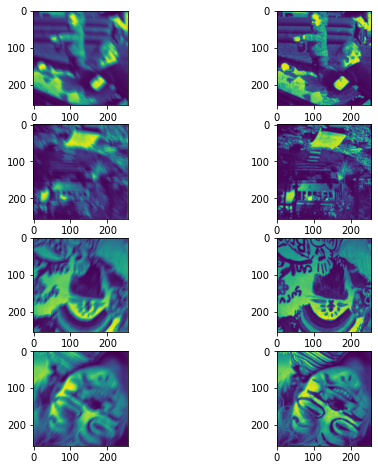

In [59]:
m.show_batch(4)

In [54]:
m.set_size(32)

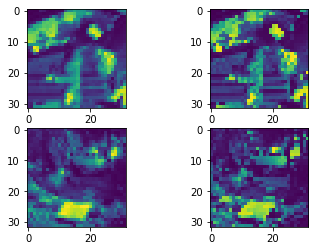

In [55]:
m.show_batch()